# Auswertung der Daten der Wiener Linien Teil 1

Um Daten aus dem Web laden zu können, definieren wir eine Funktion *loadFromWeb*. Zum Laden von
CSV Dateien gibt es mit *read_csv* eine fertige Methode im Pandas Paket. Diese Methode kann auch
von URLs lesen. Wir übergeben das Trennzeichen (Parameter *sep*) und den Zeichensatz (*encoding*).

In [1]:
import pandas as pd, numpy as np

def loadFromWeb(url):
    return pd.read_csv(url, sep=";", encoding="utf-8")

Nun rufen wir die Funktion auf, um die Haltestellen zu laden. Der Dataframe wird ausgegeben.

In [2]:
stations = loadFromWeb("https://data.wien.gv.at/csv/wienerlinien-ogd-haltestellen.csv")
display(stations)

,HALTESTELLEN_ID,TYP,DIVA,NAME,GEMEINDE,GEMEINDE_ID,WGS84_LAT,WGS84_LON,STAND
0,214460106,stop,60200001,Schrankenberggasse,Wien,90001,48.173801,16.389807,NaN
1,214460107,stop,60200002,Achengasse,Wien,90001,48.284526,16.448898,NaN
2,214460108,stop,60200003,Ada-Christen-Gasse,Wien,90001,48.152866,16.385954,NaN
3,214460109,stop,60200004,Adam-Betz-Gasse,Wien,90001,48.215611,16.535191,NaN
4,214460110,stop,60200005,Adamovichgasse,Wien,90001,48.142167,16.337840,NaN
...,...,...,...,...,...,...,...,...,...
2046,439929973,stop,60201924,Wildgartenallee,Wien,90001,48.159440,16.295646,NaN
2047,528742125,stop,60201928,Altmannsdorfer Anger,Wien,90001,NaN,NaN,NaN
2048,528848252,stop,60201928,Altmannsdorfer Anger,Wien,90001,NaN,NaN,NaN
2049,528848255,stop,60201929,Käthe-Recheis-Gasse,Wien,90001,48.228736,16.512005,NaN


## Gruppierungen

Wie viele Haltestellen gibt es pro Gemeinde? Das können wir mit einer Gruppierung
lösen. Der Rückgabewert von *groupby* ist eine Series, da sie nur eine Spalte besitzt.
Die Gruppierungsspalte wird zum *Index*.

In [3]:
grouped = stations.groupby("GEMEINDE").size()
print(type(grouped))
display(grouped)
display(grouped["Wien"])         # 1877
display(grouped[grouped > 100])  # Wien hat mehr als 100 Haltestellen

<class 'pandas.core.series.Series'>


GEMEINDE
Absdorf-Hippersdorf    1
Achau                  1
Atzenbrugg             1
Bad Deutsch-Altenbg    1
Bad Vöslau             1
                      ..
Wilfleinsdorf          1
Wolfsthal              1
Wolkersdorf/Weinvtl    1
Zeiselmauer            1
Zellerndorf            1
Length: 144, dtype: int64

1877

GEMEINDE
Wien    1877
dtype: int64

Wir können auch nach mehreren Spalten gruppieren und die Anzahl feststellen. Es entsteht ein
*hierarchischer Index*:

In [4]:
grouped=stations.groupby(["TYP", "GEMEINDE"]).size()
display(grouped)
display(grouped["stop", "Zeiselmauer"])  # 1; Zugriff auf ein Element der Gruppierung mit 2 Keys

TYP   GEMEINDE           
stop  Absdorf-Hippersdorf    1
      Achau                  1
      Atzenbrugg             1
      Bad Deutsch-Altenbg    1
      Bad Vöslau             1
                            ..
      Wilfleinsdorf          1
      Wolfsthal              1
      Wolkersdorf/Weinvtl    1
      Zeiselmauer            1
      Zellerndorf            1
Length: 144, dtype: int64

1

Wollen wir aus der Gruppierung einen Dataframe für weitere Auswertungen erzeugen, können wir mit
*DataFrame()* einen solchen auf Basis einer *Series* erzeugen. Als Parameter wird ein
Dictionary übergeben, damit wir einen Spaltennamen (z. B. count) zuweisen können.
*reset_index()* wandelt den hierarchischen Index in normale Spalten um.

In [5]:
pd.DataFrame({"count": grouped}).reset_index()

,TYP,GEMEINDE,count
0,stop,Absdorf-Hippersdorf,1
1,stop,Achau,1
2,stop,Atzenbrugg,1
3,stop,Bad Deutsch-Altenbg,1
4,stop,Bad Vöslau,1
...,...,...,...
139,stop,Wilfleinsdorf,1
140,stop,Wolfsthal,1
141,stop,Wolkersdorf/Weinvtl,1
142,stop,Zeiselmauer,1


Möchten wir die Gruppierungsspalten nicht als Index anlegen, können wir auch direkt mit *as_index=False*
arbeiten. Damit ersparen wir uns *reset_index()*. Das Thema Index wird im nächsten Notebook näher
behandelt.

In [6]:
stations.groupby(["TYP", "GEMEINDE"], as_index=False).size()

,TYP,GEMEINDE,size
0,stop,Absdorf-Hippersdorf,1
1,stop,Achau,1
2,stop,Atzenbrugg,1
3,stop,Bad Deutsch-Altenbg,1
4,stop,Bad Vöslau,1
...,...,...,...
139,stop,Wilfleinsdorf,1
140,stop,Wolfsthal,1
141,stop,Wolkersdorf/Weinvtl,1
142,stop,Zeiselmauer,1


Wir können mit *aggregate()* mehrere Aggregierungen pro Spalte vornehmen. Die Funktion bekommt
ein *Dictionary*. Diese Datenstruktur in Python ist ein Key/Value Speicher, ähnlich einem JSON.
Pro Spalte werden die Aggregierungsfunktionen als Liste angegeben. Der Rückgabewert ist ein DataFrame,
er hat eine hierarchische Spaltenbezeichnung.

In [7]:
stationsPerGemeinde = stations.groupby(["GEMEINDE_ID", "GEMEINDE"], as_index=False) \
    .aggregate({"WGS84_LAT": ["max", "min", "mean"], "WGS84_LON": ["max", "min", "mean"]})
print(type(stationsPerGemeinde))
display(stationsPerGemeinde)

<class 'pandas.core.frame.DataFrame'>


GEMEINDE_ID         GEMEINDE  WGS84_LAT                        WGS84_LON   
                                        max        min       mean        max   
0         30201     Oberradlberg  48.240709  48.240709  48.240709  15.670517  \
1         30201        St Pölten  48.220824  48.208194  48.214509  15.641493   
2         30201    Unterradlberg  48.254784  48.254784  48.254784  15.686337   
3         30201         Viehofen  48.231129  48.231129  48.231129  15.653440   
4         30401  Wiener Neustadt  47.834527  47.811589  47.826573  16.255347   
..          ...              ...        ...        ...        ...        ...   
139       32305   Untereggendorf  47.861227  47.861227  47.861227  16.321302   
140       32307        Felixdorf  47.886830  47.886830  47.886830  16.248143   
141       32327         Sollenau  47.898004  47.898004  47.898004  16.245762   
142       32330    Theresienfeld  47.860498  47.860498  47.860498  16.244038   
143       90001             Wien  48.311424  48.122436  48.205134  16.544300   

                           
           min       mean  
0    15.670517  15.670517  
1    15.624038  15.632766  
2    15.686337  15.686337  
3    15.653440  15.653440  
4    16.233734  16.242591  
..         ...        ...  
139  16.321302  16.321302  
140  16.248143  16.248143  
141  16.245762  16.245762  
142  16.244038  16.244038  
143  16.197945  16.373306  

[144 rows x 8 columns]

Möchten wir eine Spalte ausgeben, verwenden wir alle Teile der Spaltenbezeichnung.

In [8]:
stationsPerGemeinde["WGS84_LAT", "max"]

0      48.240709
1      48.220824
2      48.254784
3      48.231129
4      47.834527
         ...    
139    47.861227
140    47.886830
141    47.898004
142    47.860498
143    48.311424
Name: (WGS84_LAT, max), Length: 144, dtype: float64

Gibt es doppelt vorkommende Namen bei den Haltestellen?

In [9]:
stations[stations.duplicated("NAME", keep=False) == True]

,HALTESTELLEN_ID,TYP,DIVA,NAME,GEMEINDE,GEMEINDE_ID,WGS84_LAT,WGS84_LON,STAND
1098,214461241,stop,60201161,Scheibenbergstraße,Wien,90001,48.232428,16.318077,NaN
1135,214461280,stop,60201202,Scheibenbergstraße,Wien,90001,48.238860,16.318149,NaN
2047,528742125,stop,60201928,Altmannsdorfer Anger,Wien,90001,NaN,NaN,NaN
2048,528848252,stop,60201928,Altmannsdorfer Anger,Wien,90001,NaN,NaN,NaN


## Apply: Zeilenweises Anwenden einer Funktion

> **Hinweis:** Das zeilenweise Anwenden ist eine sehr langsame Operation.
> Verwende wenn möglich spaltenbasierende Operationen.

Wir berechnen nun die Entfernung jeder Haltestelle von der Schule
(LAT:  48°11'9"N, LNG: 16°21'24"E)?
Dafür erstellen wir einen neuen Dataframe, um die Spalte nicht zum Original hinzuzufügen.
Die Entfernung lässt sich näherungsweise mit der Formel
*d = acos( sin φ1 ⋅ sin φ2 + cos φ1 ⋅ cos φ2 ⋅ cos Δλ ) ⋅ R* berechnen.

In [10]:
import math
def calcDistance(lat, lng):
    rad=math.pi/180
    lat_school=48+11/60+9/3600
    lng_school=16+21/60+24/3600
    return math.acos(math.sin(lat_school*rad) * math.sin(lat*rad) + math.cos(lat_school*rad) * math.cos(lat*rad) * math.cos((lng-lng_school)*rad)) * 6371000

Mit *apply* können wir eine Funktion für jede Zeile oder jede Spalte im Dataframe anwenden. Mit
*axis=1* wenden wir für jede Zeile den übergebenen Ausdruck an. Imperativ würden wir das mit einer
Schleife lösen, die die Funktion für jede Zeile aufruft und das Ergebnis in die entsprechende
Zeile schreibt.

**axis=1** wird oft vergessen. Der Standardwert ist ein spaltenweises Anwenden, wo das Argument
eine Series wäre. Viele Fehler sind darauf zurückzuführen.

Nun können wir leicht feststellen, welche Stationen unter 500m von der Schule entfernt sind.

In [11]:
distances=stations.copy(deep=True)
distances["DIST"] = distances.apply(lambda row: calcDistance(row.WGS84_LAT, row.WGS84_LON), axis=1)
distances[distances.DIST < 500].sort_values("DIST")[["NAME", "DIST"]]

,NAME,DIST
1211,Spengergasse,133.752751
301,Fendigasse,220.777990
102,Bacherplatz,268.251457
1028,Reinprechtsdf. Str./Arbeiterg.,271.532910
1164,Siebenbrunnengasse,281.339646
1411,Zentaplatz,291.617516
1011,Ramperstorffergasse,292.693422
571,Jahngasse,296.259725
202,Castelligasse,335.580608
1092,Scalagasse,392.892916


## Describe und Plot

Für einen ersten Überblick über die Daten können wir mit *describe()* eine deskriptive Statistik
anzeigen lassen. Ein Histogramm lässt sich auch leicht zeichnen.

count     2042.000000
mean      8659.653975
std       8421.269291
min        133.752751
25%       4373.938623
50%       6830.831056
75%      10136.960990
max      69675.686347
Name: DIST, dtype: float64


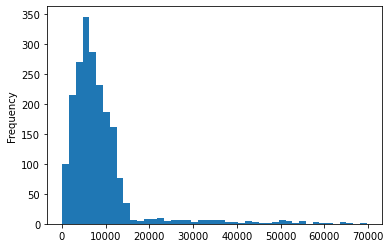

In [12]:
print(distances["DIST"].describe())
# Der Strichpunkt (;) verhindert die Ausgabe des Rückgabewertes (Axis info)
distances.DIST.plot.hist(bins=int(math.sqrt(len(distances))));

Nun wollen wir die Haltestellen nach Entfernungsklassen aufteilen. Nahe Stationen sind unter 1km
entfernt, mittlere Entfernung bis 5km, darüber hinaus weit entfernt.

In Python ist die bedingte Zuweisung mit *valueIfTrue if condition else valueIfFalse* implementiert.

In [13]:
distances["CLASS"] = distances.apply(lambda row: "near" if row.DIST < 1000 else "mid" if row.DIST < 5000 else "far", axis=1)
distances.groupby("CLASS").size()

CLASS
far     1419
mid      594
near      38
dtype: int64

Die Verwendung der *where* Funktion aus dem Numpy Paket ist schneller, da sie spaltenbasierend arbeitet.
Vermeide - wenn immer möglich - *apply*.

In [14]:
distances["CLASS"] = np.where(distances.DIST < 1000, "near", np.where(distances.DIST < 5000, "mid", "far"))
distances.groupby("CLASS").size()

CLASS
far     1419
mid      594
near      38
dtype: int64